In [2]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import pickle
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Autosaving every 180 seconds


In [14]:
#load data
# # sample dataset ---------
# estimates = np.loadtxt("Ford_estimates_v3.txt")
# pred_stds = np.loadtxt("Ford_pred_stds_v3.txt")
# ground_truth = np.loadtxt("E:/Ford/IJRR-Dataset-1-subset/SCANS/truth.txt")
# runlen = np.shape(estimates)[0]
# vf = ground_truth[:runlen,1]/10
# #-------------------------

#drive 1 dataset ---------
estimates = np.loadtxt("Ford_full_estimates_v5.txt")
pred_stds = np.loadtxt("Ford_full_pred_stds_v5.txt")
ground_truth = np.loadtxt("E:/Ford/IJRR-Dataset-1/SCANS/truth.txt")
runlen = np.shape(estimates)[0]

estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]

# vf = ground_truth[:runlen-1,1]/10
# vf = ground_truth[60:(runlen+60),1]/10 #skip the first 61 frames (at standstill) and begin at onset of motion
# vf = (ground_truth[981:(runlen+981-1),1]/10 + ground_truth[980:(runlen+980-1),1]/10)/2 #v3
# vf = (ground_truth[2200:(runlen+2200-1),1]/10 + ground_truth[2201:(runlen+2201-1),1]/10)/2 #v4
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5
#-------------------------
# print(np.shape(vf))
# print(np.shape(pred_stds))

# print(np.shape(ground_truth))

# print(pred_stds)

# print(estimates[:,1])

<IPython.core.display.Javascript object>


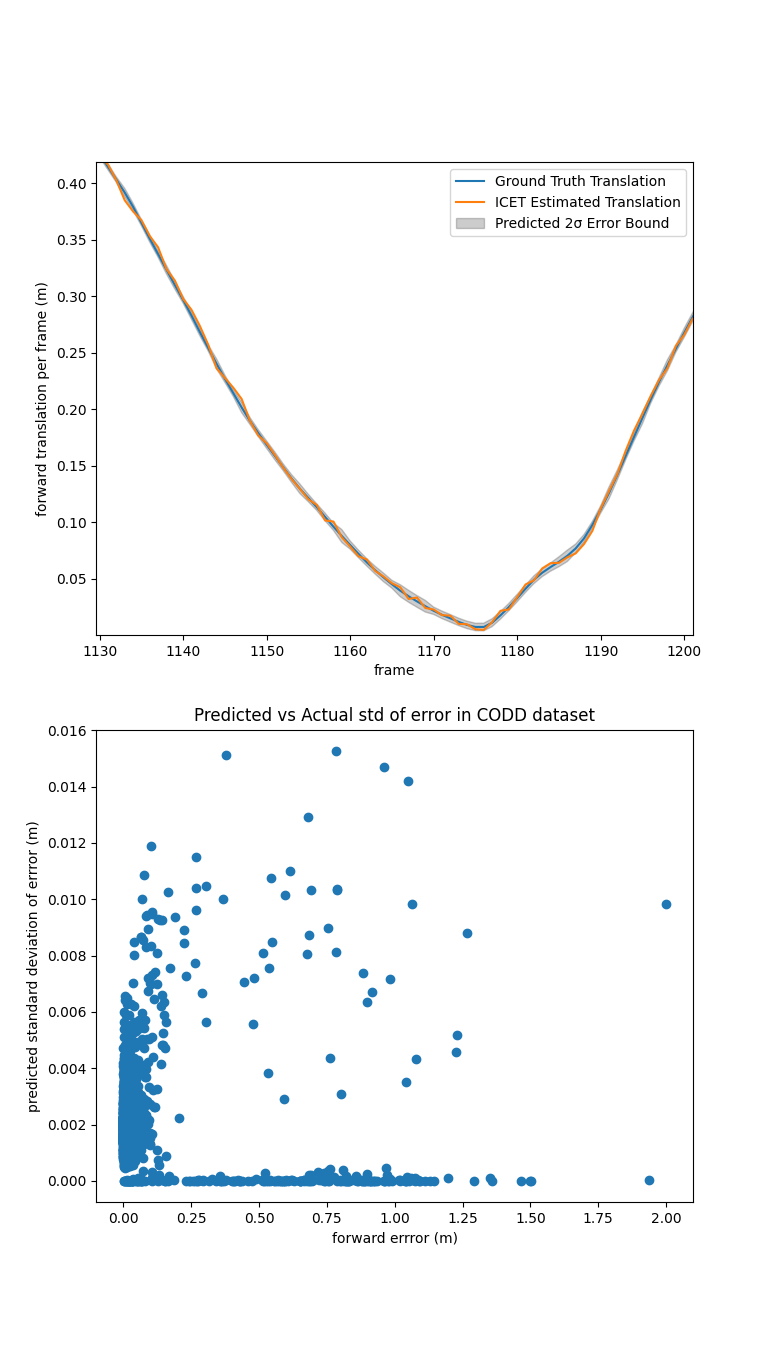

(3809,)
(3809, 6)
correlation: 
 [[ 1.         -0.02000621]
 [-0.02000621  1.        ]]


In [15]:
fig, ax = plt.subplots(2,1)

ax[0].plot(vf, label = 'Ground Truth Translation')

# vf = vf[:runlen]
# vf = vf[:runlen-1]
print(np.shape(vf))
print(np.shape(pred_stds))


# print(estimates[:,0])
ax[0].plot(estimates[:,1], label = "ICET Estimated Translation")
# ax[0].plot(estimates[:,0] + pred_stds[:,0], color = [0,0,0], alpha = 0.1)
# ax[0].plot(estimates[:,0] - pred_stds[:,0], color = [0,0,0], alpha = 0.1)

#NOTE-- adjust linspace here when shifting
ax[0].fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
# ax[0].fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
#                    color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')

ax[0].set_xlabel("frame")
ax[0].set_ylabel("forward translation per frame (m)")
ax[0].legend(loc = 'best')
# ax[0].set_tile("Simple Outlier Rejection")

ferr = vf - estimates[:,1]
# ax[1].plot(abs(ferr))
# ax[1].plot(pred_stds[:,0])
ax[1].scatter(abs(ferr), pred_stds[:,1])
ax[1].set_xlabel("forward errror (m)")
ax[1].set_ylabel("predicted standard deviation of errror (m)")
ax[1].set_title("Predicted vs Actual std of error in CODD dataset")

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,1]))
# print(np.sum(ferr))
# print(np.sum(vf))

[ 0.00000000e+00  9.11950812e-02 -1.10914973e-03  3.99249518e-03
  2.20886751e-03  3.55465364e-06]


<IPython.core.display.Javascript object>


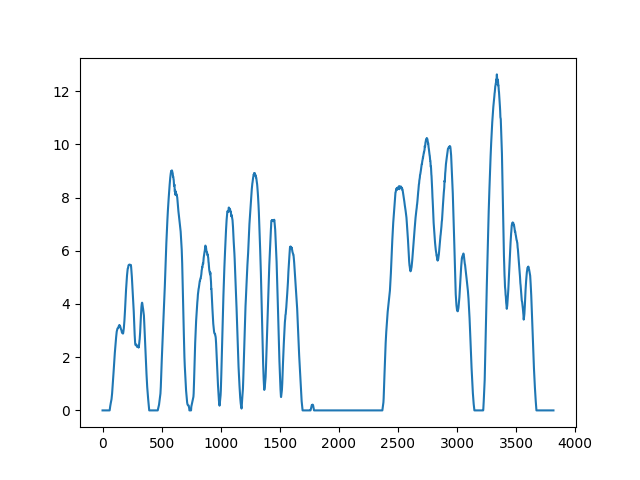

In [74]:
print(ground_truth[1189]/10)
fig, ax = plt.subplots()
ax.plot(ground_truth[:,1])

<IPython.core.display.Javascript object>


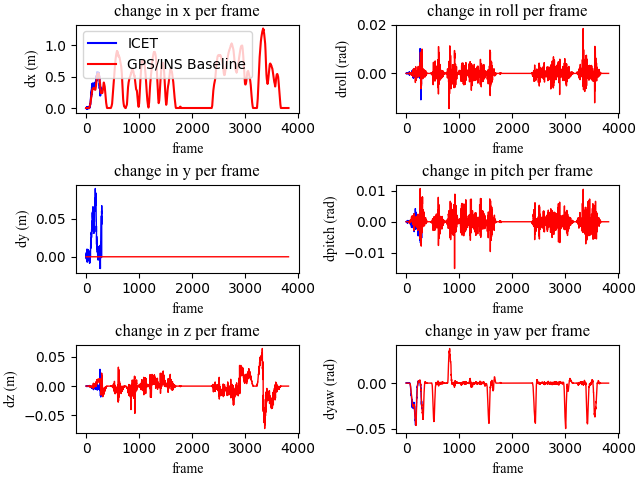

In [20]:
font = {'fontname':'Times New Roman'}
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(estimates[:,1] + estimates[:,0], style1, label = 'ICET')
ax[0,0].plot(ground_truth[:,1]*.1, style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.sqrt(ground_truth[:,0]**2 + ground_truth[:,1]**2), style2, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(estimates[:,0], style1, lw = 1)
ax[1,0].plot(ground_truth[:,0]*.1, style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)


ax[2,0].plot(estimates[:,2], style1, lw = 1)
ax[2,0].plot(-ground_truth[:,2]*.1, style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(estimates[:,3], style1, lw = 1)
ax[0,1].plot(ground_truth[:,3]*.1, style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)


ax[1,1].plot(estimates[:,4], style1, lw = 1)
ax[1,1].plot(ground_truth[:,4]*.1, style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)


ax[2,1].plot(estimates[:,5], style1, lw = 1)
ax[2,1].plot(ground_truth[:,5]*.1, style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

In [ ]:
print(ground_truth[134])

In [ ]:
# print(tf.random.normal([1]).numpy()[0])
test = tf.random.normal([2,3])
print(test + tf.constant([10., 10., 10.]))

In [ ]:
75 + 61